In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
#import tensorflow_addons
#import tensorflow_probability as tfp

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

In [2]:
#!pip install tensorflow_probability

In [3]:
col_names = ['Flex', 'Laz', 'st_volt', 'end_volt', 'time_step', 'tot_time']#, 'time_step', 'total_time']

data_filepath0 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed0.csv'
data_filepath1 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed1.csv'
data_filepath2 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed2.csv'
data_filepath3 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed3.csv'
data_filepath4 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed4.csv'
data_filepath5 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed5.csv'
data_filepath6 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed6.csv'
#data_filepath7 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed7.csv'
data_filepath8 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed8.csv'
data_filepath9 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed9.csv'
data_filepath10 = 'data/MFC_dynamics_data0_step2_range31_shuffle_seed10.csv'

raw_data0 = pd.read_csv(data_filepath0, names=col_names, na_values = '?', comment='\t', sep=',')
raw_data1 = pd.read_csv(data_filepath1, names=col_names, na_values = '?', comment='\t', sep=',')
raw_data2 = pd.read_csv(data_filepath2, names=col_names, na_values = '?', comment='\t', sep=',')
raw_data3 = pd.read_csv(data_filepath3, names=col_names, na_values = '?', comment='\t', sep=',')
raw_data4 = pd.read_csv(data_filepath4, names=col_names, na_values = '?', comment='\t', sep=',')
raw_data5 = pd.read_csv(data_filepath5, names=col_names, na_values = '?', comment='\t', sep=',')
raw_data6 = pd.read_csv(data_filepath6, names=col_names, na_values = '?', comment='\t', sep=',')
#raw_data7 = pd.read_csv(data_filepath7, names=col_names, na_values = '?', comment='\t', sep=',')
raw_data8 = pd.read_csv(data_filepath8, names=col_names, na_values = '?', comment='\t', sep=',')
#test dataset
raw_data9 = pd.read_csv(data_filepath9, names=col_names, na_values = '?', comment='\t', sep=',')
raw_data10 = pd.read_csv(data_filepath10, names=col_names, na_values = '?', comment='\t', sep=',')

def clean_data(df):
    df = df[df['Flex']<1023]
    df = df[df['Laz']>0]
    
    df['last_laz'] = df['Laz'].shift(periods=1)
    df.dropna(subset = ['last_laz'], inplace=True)
    
    #df['flex_diff'] = df['Flex'].diff()
    #df.dropna(subset = ['flex_diff'], inplace=True)
    
    df.drop('Laz', inplace = True, axis=1)
    df.drop('time_step', inplace=True, axis=1)
    df.drop('st_volt', inplace=True, axis=1)
    df.drop('end_volt', inplace=True, axis=1)
    #df.drop('Flex', inplace=True, axis=1)
    #df.drop('Laz', inplace=True, axis=1)
    df.drop('tot_time', inplace=True, axis = 1)
    return df

raw_data = []
print('Cleaning Data...')
data0 = clean_data(raw_data0)
raw_data.append(data0)
print('..data0..')
data1 = clean_data(raw_data1)
raw_data.append(data1)
print('..data1..')
data2 = clean_data(raw_data2)
raw_data.append(data2)
print('..data2..')
data3 = clean_data(raw_data3)
raw_data.append(data3)
print('..data3..')
data4 = clean_data(raw_data4)
raw_data.append(data4)
print('..data4..')
data5 = clean_data(raw_data5)
raw_data.append(data5)
print('..data5..')
data6 = clean_data(raw_data6)
raw_data.append(data6)
print('..data6..')
data8 = clean_data(raw_data8)
raw_data.append(data8)
print('..data8..')
data9 = clean_data(raw_data9)
raw_data.append(data9)
print('..done cleaning..')

cleaned_data = pd.concat(raw_data, axis=0, ignore_index=True)

dataset = cleaned_data.copy()
df = dataset #dataset[5::6]
df.head()


Cleaning Data...
..data0..
..data1..
..data2..
..data3..
..data4..
..data5..
..data6..
..data8..
..done cleaning..


,Flex,last_laz
0,751.0,550.0
1,748.0,550.0
2,747.0,555.0
3,747.0,570.0
4,748.0,572.0


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Flex,2409593.0,760.571349,68.733912,612.0,703.0,757.0,818.0,920.0
last_laz,2409593.0,495.819635,225.281801,44.0,297.0,503.0,703.0,890.0


### Data info for normalizaton

In [5]:
df_mean = df.mean()
df_std = df.std()

def normalize_df(df):
    df = (df-df_mean)/df_std
    return df



## Data windowing
    

In [6]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] 
                              for name in self.label_columns],
                             axis=-1)
        
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the tf.data.Datasets are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def plot(self, model=None, plot_col='Laz', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data,
                                                                 targets=None,
                                                                 sequence_length=self.total_window_size,
                                                                 sequence_stride=1,
                                                                 shuffle=True,
                                                                 batch_size=100,) #was 32
        ds = ds.map(self.split_window)
        return ds
    
    

In [7]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of inputs, labels for plotting"""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the .train dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example=result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [8]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
    callback = [tf.keras.callbacks.EarlyStopping(patience=7),
                    tf.keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
                    tf.keras.callbacks.ModelCheckpoint('flex_to_laz_mlp.hdf', save_best_only=True, save_weights_only=True)]
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                 metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=callback)
    return history

In [9]:
val_performance = {}
performance = {}

In [10]:
def train_model(model, dataframe, test, window = False, is_clean=False):
    
    df = dataframe.copy()
    test = test.copy()
    
    if is_clean:
        df = dataframe
    else:    
        df = clean_data(df)
    
    test = clean_data(test)
    
    print(df.tail())
    print(test.tail())

    
    df = normalize_df(df)
    test = normalize_df(test)
    
    col_indices = {name: i for i, name in enumerate(df.columns)}

    n = len(df)
    train_df = df[:int(0.8*n)]
    val_df = df[int(0.8*n):]
    test_df = test

    num_features = df.shape[1]
    
    print(f'num features: {num_features}')
    
    CONV_WIDTH = 10
    conv_window = WindowGenerator(input_width=CONV_WIDTH,
                                 label_width=1,
                                 shift=1,
                                 label_columns=['last_laz'],
                                 train_df=train_df,
                                 val_df=val_df,
                                 test_df=test_df)
    
    history = compile_and_fit(model, conv_window)
    model.load_weights('flex_to_laz_mlp.hdf')

    if window:
        return model, conv_window
    else:
        return model
    
  
    


## Multi step dense

In [11]:
# Create Model Combined Training

                                        #Shape: (time, features) => (time*features)
multi_step_dense = tf.keras.Sequential([tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(units=128, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(units=32, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(units=1),
                                        # Add back the time dimension.
                                        #Shape: (outputs) => (1, outputs)
                                        tf.keras.layers.Reshape([1, -1]),
                                       ])



#multi_step_dense = train_model(multi_step_dense, raw_data, raw_data5)
multi_step_dense, conv_window = train_model(multi_step_dense, cleaned_data, raw_data10, window=True, is_clean=True)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
multi_step_dense.save('MSD_flex_to_laz_X')

4820/4820 [==============================] - 16s 3ms/step - loss: 4.5306e-04 - mean_absolute_error: 0.0127
INFO:tensorflow:Assets written to: MSD_flex_to_laz\assets


In [12]:
# Create Model Split Training

                                        #Shape: (time, features) => (time*features)
multi_step_dense = tf.keras.Sequential([tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(units=128, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(units=32, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(units=1),
                                        # Add back the time dimension.
                                        #Shape: (outputs) => (1, outputs)
                                        tf.keras.layers.Reshape([1, -1]),
                                       ])



#multi_step_dense = train_model(multi_step_dense, raw_data, raw_data5)
multi_step_dense = train_model(multi_step_dense, raw_data0, raw_data10)
multi_step_dense = train_model(multi_step_dense, raw_data1, raw_data10)
multi_step_dense = train_model(multi_step_dense, raw_data2, raw_data10)
multi_step_dense = train_model(multi_step_dense, raw_data3, raw_data10)
multi_step_dense = train_model(multi_step_dense, raw_data4, raw_data10)
multi_step_dense = train_model(multi_step_dense, raw_data5, raw_data10)
multi_step_dense = train_model(multi_step_dense, raw_data6, raw_data10)
#multi_step_dense = train_model(multi_step_dense, raw_data7, raw_data10)
multi_step_dense = train_model(multi_step_dense, raw_data8, raw_data10)
multi_step_dense, conv_window = train_model(multi_step_dense, raw_data9, raw_data10, window=True)

IPython.display.clear_output()
val_performance['Multi step dense split'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense split'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
multi_step_dense.save('MSD_split_flex_to_laz_X')

534/534 [==============================] - 2s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0297
INFO:tensorflow:Assets written to: MSD_split_flex_to_laz\assets


## CNN model

In [13]:
# Create model
CONV_WIDTH = 10
conv_model = tf.keras.Sequential([tf.keras.layers.Conv1D(filters=128,
                                                        kernel_size=(CONV_WIDTH,),
                                                        activation='relu'),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Dense(units=32, activation='relu'),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Dense(units=1),
                                  tf.keras.layers.Reshape([1, -1]),
                                 ])

conv_model, conv_window = train_model(conv_model, cleaned_data, raw_data10, window=True, is_clean=True)

IPython.display.clear_output()
val_performance['CNN'] = conv_model.evaluate(conv_window.val)
performance['CNN'] = conv_model.evaluate(conv_window.test, verbose=0)
conv_model.save('CNN_flex_to_laz_X')

4820/4820 [==============================] - 14s 3ms/step - loss: 4.9754e-04 - mean_absolute_error: 0.0143
INFO:tensorflow:Assets written to: CNN_flex_to_laz\assets


In [14]:
# Create model
CONV_WIDTH = 10
conv_model = tf.keras.Sequential([tf.keras.layers.Conv1D(filters=128,
                                                        kernel_size=(CONV_WIDTH,),
                                                        activation='relu'),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Dense(units=32, activation='relu'),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Dense(units=1),
                                  tf.keras.layers.Reshape([1, -1]),
                                 ])

conv_model = train_model(conv_model, raw_data0, raw_data10)
conv_model = train_model(conv_model, raw_data1, raw_data10)
conv_model = train_model(conv_model, raw_data2, raw_data10)
conv_model = train_model(conv_model, raw_data3, raw_data10)
conv_model = train_model(conv_model, raw_data4, raw_data10)
conv_model = train_model(conv_model, raw_data5, raw_data10)
conv_model = train_model(conv_model, raw_data6, raw_data10)
#conv_model = train_model(conv_model, raw_data7, raw_data10)
conv_model = train_model(conv_model, raw_data8, raw_data10)
conv_model, conv_window = train_model(conv_model, raw_data9, raw_data10, window=True)

IPython.display.clear_output()
val_performance['CNN split'] = conv_model.evaluate(conv_window.val)
performance['CNN split'] = conv_model.evaluate(conv_window.test, verbose=0)
conv_model.save('CNN_split_flex_to_laz_X')

534/534 [==============================] - 2s 3ms/step - loss: 4.1250e-04 - mean_absolute_error: 0.0132
INFO:tensorflow:Assets written to: CNN_split_flex_to_laz\assets


## LSTM model

In [11]:
# Create Model
CONV_WIDTH = 10
                                # Shape [batch, time, features] +> [batch, time, lstm_units]
lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(128, return_sequences=False, input_shape=(CONV_WIDTH,2) ),
                                            # Shape => [batch, time, features]
                                            tf.keras.layers.Dense(units=1),
                                            #tf.keras.layers.Reshape([1, -1]),
                                            ])


lstm_model, conv_window = train_model(lstm_model, cleaned_data, raw_data10, window=True, is_clean=True)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(conv_window.val)
performance['LSTM'] = lstm_model.evaluate(conv_window.test, verbose=0)

lstm_model.save('LSTM_flex_to_laz_X')

4820/4820 [==============================] - 32s 7ms/step - loss: 2.7145e-04 - mean_absolute_error: 0.0083
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: LSTM_flex_to_laz\assets


In [12]:
# Create Model
CONV_WIDTH = 10
                                # Shape [batch, time, features] +> [batch, time, lstm_units]
lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(128, return_sequences=False, input_shape=(CONV_WIDTH, 2) ),
                                            # Shape => [batch, time, features]
                                            tf.keras.layers.Dense(units=1),
                                            tf.keras.layers.Reshape([1, -1]),
                                            ])

lstm_model = train_model(lstm_model, raw_data0, raw_data10)
lstm_model = train_model(lstm_model, raw_data1, raw_data10)
lstm_model = train_model(lstm_model, raw_data2, raw_data10)
lstm_model = train_model(lstm_model, raw_data3, raw_data10)
lstm_model = train_model(lstm_model, raw_data4, raw_data10)
lstm_model = train_model(lstm_model, raw_data5, raw_data10)
lstm_model = train_model(lstm_model, raw_data6, raw_data10)
#lstm_model = train_model(lstm_model, raw_data7, raw_data10)
lstm_model = train_model(lstm_model, raw_data8, raw_data10)
lstm_model, conv_window = train_model(lstm_model, raw_data9, raw_data10, window=True)

IPython.display.clear_output()
val_performance['LSTM split'] = lstm_model.evaluate(conv_window.val)
performance['LSTM split'] = lstm_model.evaluate(conv_window.test, verbose=0)

lstm_model.save('LSTM_split_flex_to_laz_X')

534/534 [==============================] - 3s 6ms/step - loss: 2.5268e-04 - mean_absolute_error: 0.0083
INFO:tensorflow:Assets written to: LSTM_split_flex_to_laz\assets


## Compare

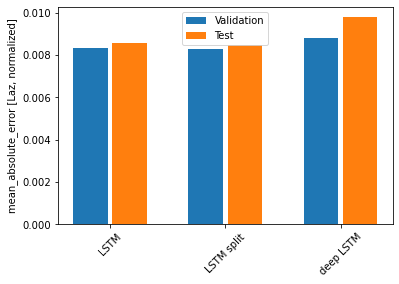

In [15]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Laz, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()